# **Project Description**
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data:
* technical specifications
* trim versions
* prices

You need to build the model to determine the value.

Rusty Bargain is interested in:

* the quality of the prediction (*RMSE aka SQRT(MSE)*)
* the speed of the prediction (*how quickly the model can generate predictions for new, unseen data*)
* the time required for training (*time it takes to learn the learning the underlying patterns and relationships in the data*)

## **Project Instructions**
1. Download and look at the data
2. Train different models with various hyperparameters
  * You should make at least two different models, but more is better
  * Remember, various implementations of gradient boosting don't count as different models
  *  The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression
3. Analyze the speed and quality of the models



---



## **Notes**

* Use the RMSE metric to evaluate the models
* Linear regression is not very good for hyperparameter tuning, but it is perfect for doing a sanity check of other methods. If gradient boosting performs worse than linear regression, something definitely went wrong
* On your own, work with the LightGBM library and use its tools to build gradient boosting models
* Ideally, your project should include linear regression for a sanity check, a tree-based algorithm with hyperparameter tuning (preferably, random forest), LightGBM with hyperparameter tuning (try a couple of sets), and CatBoost and XGBoost with hyperparameter tuning (optional)
* Take note of the encoding of categorical features for simple algorithms. LightGBM and CatBoost have their implementation, but XGBoost requires OHE
* You can use a special command to find the cell code runtime in Jupyter Notebook. Find that command
* Since the training of a gradient boosting model can take a long time, change only a few model parameters
* If Jupyter Notebook stops working, delete the excessive variables by using the del operator: #del features_train

# **Initialization**

In [ ]:
!pip install catboost

In [ ]:
!pip install dask[dataframe]

In [ ]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Pre-processing Packages
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

# Model Initialization
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Model Sets
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


# Model Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score
import timeit
from joblib import Parallel, delayed

In [ ]:
car_data_root = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv')

print(car_data_root.head(5))

print(car_data_root.info())

display(car_data_root.describe())

        DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  24/03/2016 11:52    480         NaN              1993  manual      0   
1  24/03/2016 10:58  18300       coupe              2011  manual    190   
2  14/03/2016 12:52   9800         suv              2004    auto    163   
3  17/03/2016 16:54   1500       small              2001  manual     75   
4  31/03/2016 17:25   3600       small              2008  manual     69   

   Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf   150000                  0    petrol  volkswagen         NaN   
1    NaN   125000                  5  gasoline        audi         yes   
2  grand   125000                  8  gasoline        jeep         NaN   
3   golf   150000                  6    petrol  volkswagen          no   
4  fabia    90000                  7  gasoline       skoda          no   

        DateCreated  NumberOfPictures  PostalCode          LastSeen  
0  24/03/2016 00:00               

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
def qa_check(df):
    print(f"Checking {df.shape[0]} rows and {df.shape[1]} columns in DataFrame...")

    # Check data structure
    df.info()

    # Check for duplicates
    dup_count = df.duplicated().sum()
    print()
    print(f"Duplicates found: {dup_count}")
    print()

    # Count zeros
    zero_cols = {}
    for col in df.columns:
        zero_count = (df[col] == 0).sum()
        if zero_count > 0:
            zero_cols[col] = zero_count
    print("Columns with zeros:")
    for col, count in zero_cols.items():
        print(f"  {col}: {count}")
    print()

    # Count null/nan and inf/-inf
    nan_cols = {}
    for col in df.columns:
        df_inf = df[col].replace([np.inf, -np.inf], np.nan)
        nan_count = df_inf.isnull().sum()
        if nan_count > 0:
            nan_cols[col] = nan_count
    print("Columns with null/NaN values:")
    for col, count in nan_cols.items():
        print(f"  {col}: {count}")
    print()

qa_check(car_data_root)

Checking 354369 rows and 16 columns in DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen        

## **Pre-processing**

In [ ]:
print(car_data_root['VehicleType'].unique())
print()

print(car_data_root['Gearbox'].unique())
print()

print(car_data_root['FuelType'].unique())
print()

print(car_data_root['Brand'].unique())
print()

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

['manual' 'auto' nan]

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']



In [ ]:
car_data_root = car_data_root.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

In [ ]:
# Identify the columns to label encode
columns_to_encode = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

car_data_encoded = car_data_root.copy()

# Create a dictionary to store the encoders for each column
encoders = {
    'VehicleType': {'encoder': LabelEncoder(), 'mapping': {}},
    'Gearbox': {'encoder': LabelEncoder(), 'mapping': {}},
    'Model': {'encoder': LabelEncoder(), 'mapping': {}},
    'FuelType': {'encoder': LabelEncoder(), 'mapping': {}},
    'Brand': {'encoder': LabelEncoder(), 'mapping': {}},
    'NotRepaired': {'encoder': LabelEncoder(), 'mapping': {}}
}

# Apply the LabelEncoder to each column
for col in columns_to_encode:
    encoder = encoders[col]['encoder']
    car_data_encoded[col] = encoder.fit_transform(car_data_root[col])
    encoders[col]['mapping'] = {v: i for i, v in enumerate(encoder.classes_)}

In [ ]:
# Print the encoders dictionary

for col, encoder_info in encoders.items():
    print(f"Encoding mapping for {col}: {encoder_info['mapping']}")

Encoding mapping for VehicleType: {'bus': 0, 'convertible': 1, 'coupe': 2, 'other': 3, 'sedan': 4, 'small': 5, 'suv': 6, 'wagon': 7, nan: 8}
Encoding mapping for Gearbox: {'auto': 0, 'manual': 1, nan: 2}
Encoding mapping for Model: {'100': 0, '145': 1, '147': 2, '156': 3, '159': 4, '1_reihe': 5, '1er': 6, '200': 7, '2_reihe': 8, '300c': 9, '3_reihe': 10, '3er': 11, '4_reihe': 12, '500': 13, '5_reihe': 14, '5er': 15, '601': 16, '6_reihe': 17, '6er': 18, '7er': 19, '80': 20, '850': 21, '90': 22, '900': 23, '9000': 24, '911': 25, 'a1': 26, 'a2': 27, 'a3': 28, 'a4': 29, 'a5': 30, 'a6': 31, 'a8': 32, 'a_klasse': 33, 'accord': 34, 'agila': 35, 'alhambra': 36, 'almera': 37, 'altea': 38, 'amarok': 39, 'antara': 40, 'arosa': 41, 'astra': 42, 'auris': 43, 'avensis': 44, 'aveo': 45, 'aygo': 46, 'b_klasse': 47, 'b_max': 48, 'beetle': 49, 'berlingo': 50, 'bora': 51, 'boxster': 52, 'bravo': 53, 'c1': 54, 'c2': 55, 'c3': 56, 'c4': 57, 'c5': 58, 'c_klasse': 59, 'c_max': 60, 'c_reihe': 61, 'caddy': 62,

In [ ]:
# Identify the numerical columns
numerical_cols = [col for col in car_data_root.columns if col not in columns_to_encode]

# Create a KNNImputer
imputer = KNNImputer()

# Apply the KNNImputer to the numerical columns
car_data_encoded[numerical_cols] = imputer.fit_transform(car_data_encoded[numerical_cols])

# Print
print(car_data_root.sample(10, replace=False))

        Price VehicleType  RegistrationYear Gearbox  Power     Model  Mileage  \
140184   1500         NaN              2017  manual      0    megane   150000   
317140   7800         suv              2009  manual    173     other   150000   
241801   6600       small              2011  manual    101   i_reihe    50000   
82537    1000       wagon              1999     NaN      0  c_klasse   150000   
72039    1800       wagon              1998  manual    193        a6   150000   
199826   3210         bus              2005  manual    101     other   150000   
170521   2250       sedan              2000  manual    105       3er   150000   
225669   1399       sedan              1997  manual    101        a3   150000   
323535   1850       sedan              2003  manual    120       147   150000   
142726   1500       small              2005  manual     54      polo    80000   

        RegistrationMonth  FuelType          Brand NotRepaired  \
140184                 12    petrol       

**Comment:** After running the qa_check() function that I developed a few lessons ago, I found that three things. The first is that there was a high proportion of null/NaN rows across multiple columns in the matrix which would cause issues when doing calculations and visualizaitons and result in a high loss of data if simply removed. Next, was the mix of numerical and categorical data in the data frame. Lastly, was the presence of three date-time colunms. To address these, I did the following:

1. I decide to use an imputation method based on KNN to fill in the NaN values acknowledging that this could contribute to overfitting later.
2. However, prior to using the KNNImputer, I implemented a LabelEncoder() to the categorical columns ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'] to make the datatypes uniformly int64 – found this out after
3. I dropped the ['DateCrawled'], ['DateCreated'], and ['LastSeen'] columns.

I then added an encoder dictionary to keep track of the brands, fuel types, years, etc. in the next section of the analysis. Approx. 0.7% of total rows included NaN's ('nan') and could not be processed further.






## **Exploratory Data Analysis**

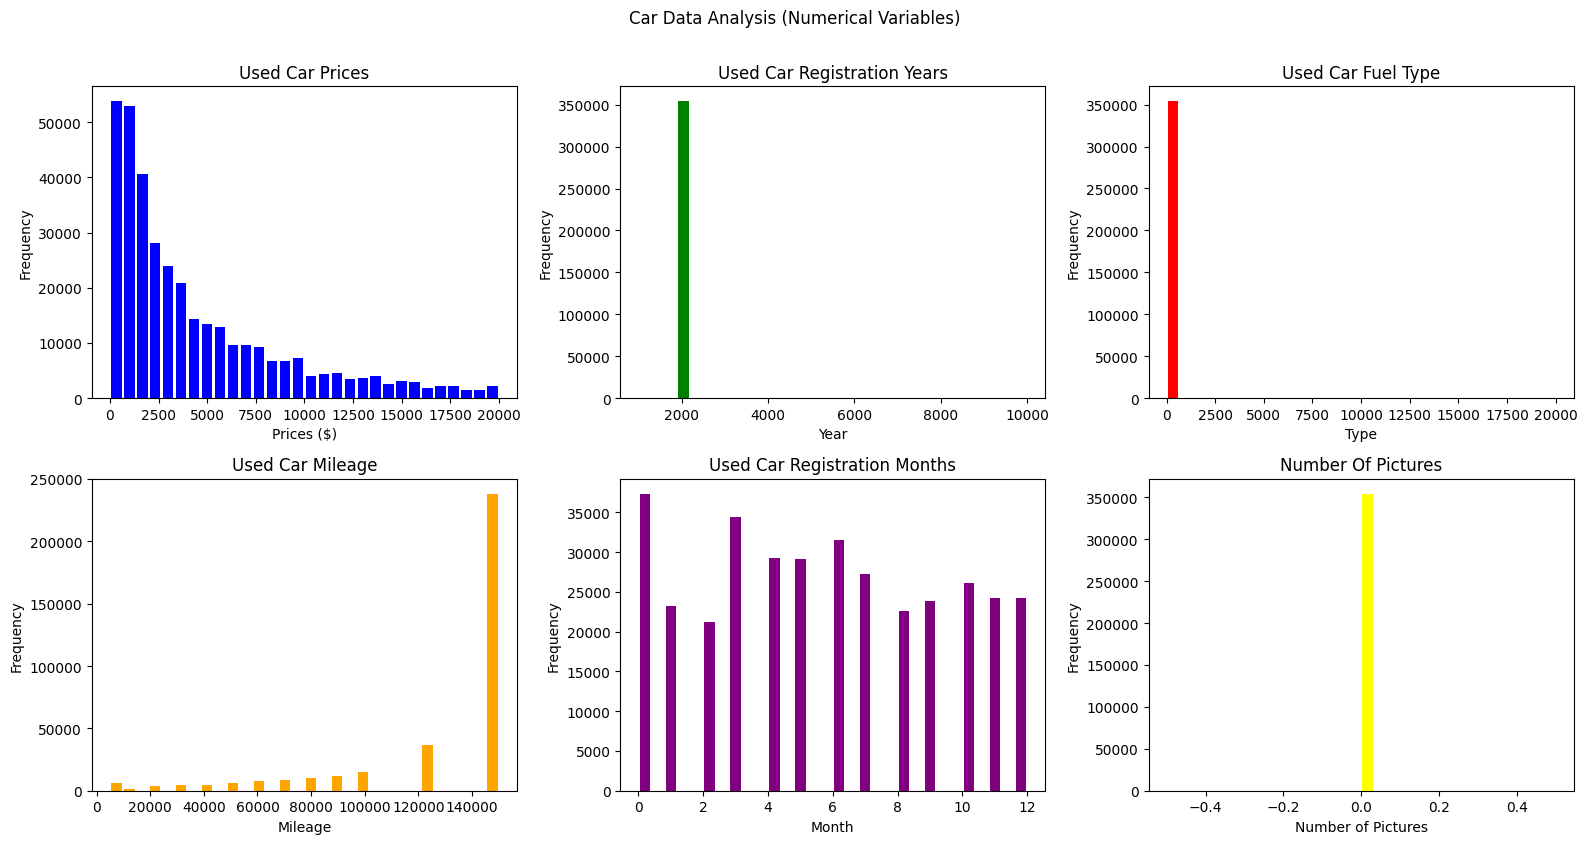

In [ ]:
# histograms: ['Price'], ['VehicleType'], ['RegistrationYear'], ['Gearbox'], ['Power'], ['Mileage'], ['RegistrationMonth'], ['FuelType'], ['NumberOfPictures']

# bins  is supposed to = int(math.sqrt(len(car_data_root))), however for visualization purposes I am using 30

# histograms: ['Price'], ['RegistrationYear'], ['Power'], ['Mileage'], ['RegistrationMonth'], ['NumberOfPictures']

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 8))

axes[0, 0].hist(car_data_encoded['Price'], bins = 30, color = 'blue', rwidth = 0.8)
axes[0, 0].set_title('Used Car Prices')
axes[0, 0].set_xlabel('Prices ($)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(car_data_encoded['RegistrationYear'], bins = 30, color = 'green', rwidth = 0.8)
axes[0, 1].set_title('Used Car Registration Years')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(car_data_encoded['Power'], bins = 30, color = 'red', rwidth = 0.8)
axes[0, 2].set_title('Used Car Fuel Type')
axes[0, 2].set_xlabel('Type')
axes[0, 2].set_ylabel('Frequency')

axes[1, 0].hist(car_data_encoded['Mileage'], bins = 30, color = 'orange', rwidth = 0.8)
axes[1, 0].set_title('Used Car Mileage')
axes[1, 0].set_xlabel('Mileage')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(car_data_encoded['RegistrationMonth'], bins = 30, color = 'purple', rwidth = 0.8)
axes[1, 1].set_title('Used Car Registration Months')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Frequency')

axes[1, 2].hist(car_data_encoded['NumberOfPictures'], bins = 30, color = 'yellow', rwidth = 0.8)
axes[1, 2].set_title('Number Of Pictures')
axes[1, 2].set_xlabel('Number of Pictures')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Car Data Analysis (Numerical Variables)', y = 1.05)
plt.show()

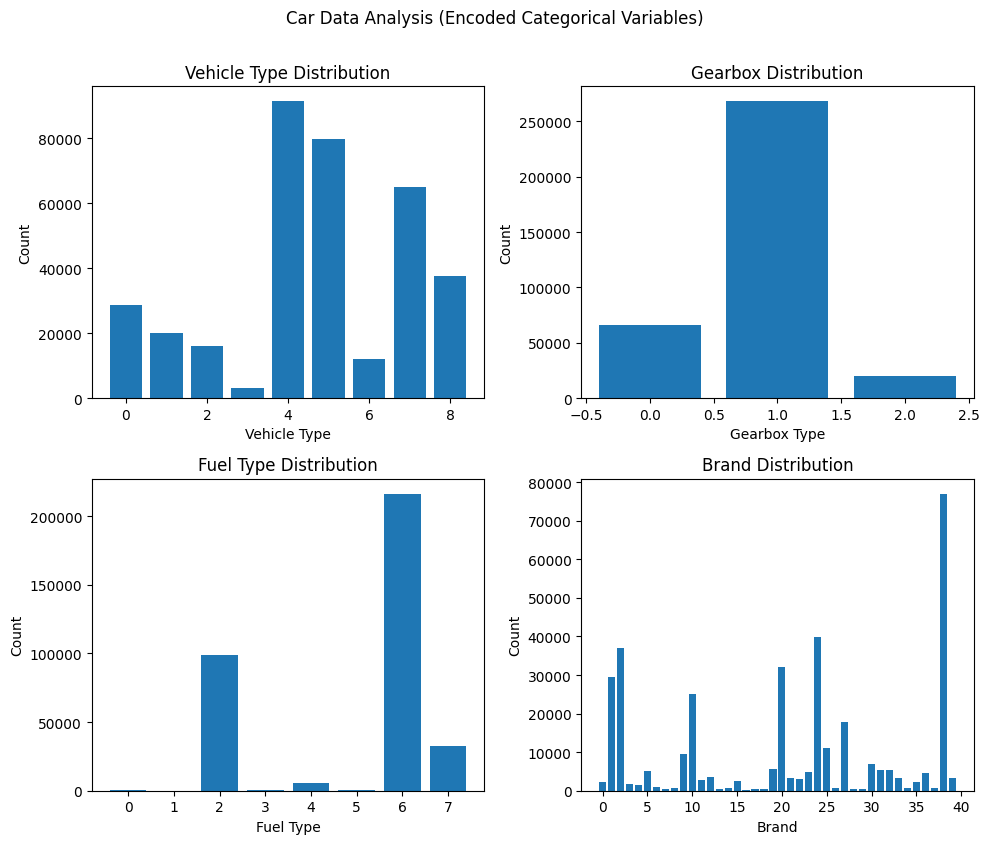

In [ ]:
# Create a figure and set of subplots
fig, axes = plt.subplots(2, 2, figsize = (10, 8))

# bar charts: ['VehicleType'], ['Gearbox'], ['FuelType'], ['Brand']

# Plot the data
axes[0, 0].bar(car_data_encoded['VehicleType'].value_counts().index, car_data_encoded['VehicleType'].value_counts())
axes[0, 1].bar(car_data_encoded['Gearbox'].value_counts().index, car_data_encoded['Gearbox'].value_counts())
axes[1, 0].bar(car_data_encoded['FuelType'].value_counts().index, car_data_encoded['FuelType'].value_counts())
axes[1, 1].bar(car_data_encoded['Brand'].value_counts().index, car_data_encoded['Brand'].value_counts())

# Set axis labels and titles
axes[0, 0].set(xlabel='Vehicle Type', ylabel='Count', title='Vehicle Type Distribution')
axes[0, 1].set(xlabel='Gearbox Type', ylabel='Count', title='Gearbox Distribution')
axes[1, 0].set(xlabel='Fuel Type', ylabel='Count', title='Fuel Type Distribution')
axes[1, 1].set(xlabel='Brand', ylabel='Count', title='Brand Distribution')

# Adjust layout and display
plt.tight_layout()
plt.suptitle('Car Data Analysis (Encoded Categorical Variables)', y = 1.05)
plt.show()

**Comment:** In this section, I wanted to explore the distributions of the data at a high level after the label encoding and KNNImputation that was previously implemented to further anticipate any irregularities. The results show that there are no entries with pictures taken ['NumberOfPictures'] > 0. ['Power] and ['RegistrationYear'] have distributions that should be investigated further. In the second set of plots, I try to identify key trends. What We see is that Sedans, small cats, wagons are the most popular vehicle type. Manual is the most popular Gearbox type. Petrol, then gasoline are the most popular fuel types. The most popular brands of cars are: Volkswagen, Opel, BMW, Mercedes-Benz, Audi, then Ford. ['Model'] is too complex a range of values, so not encoded or visualized.

## **Statistical Data Analysis**

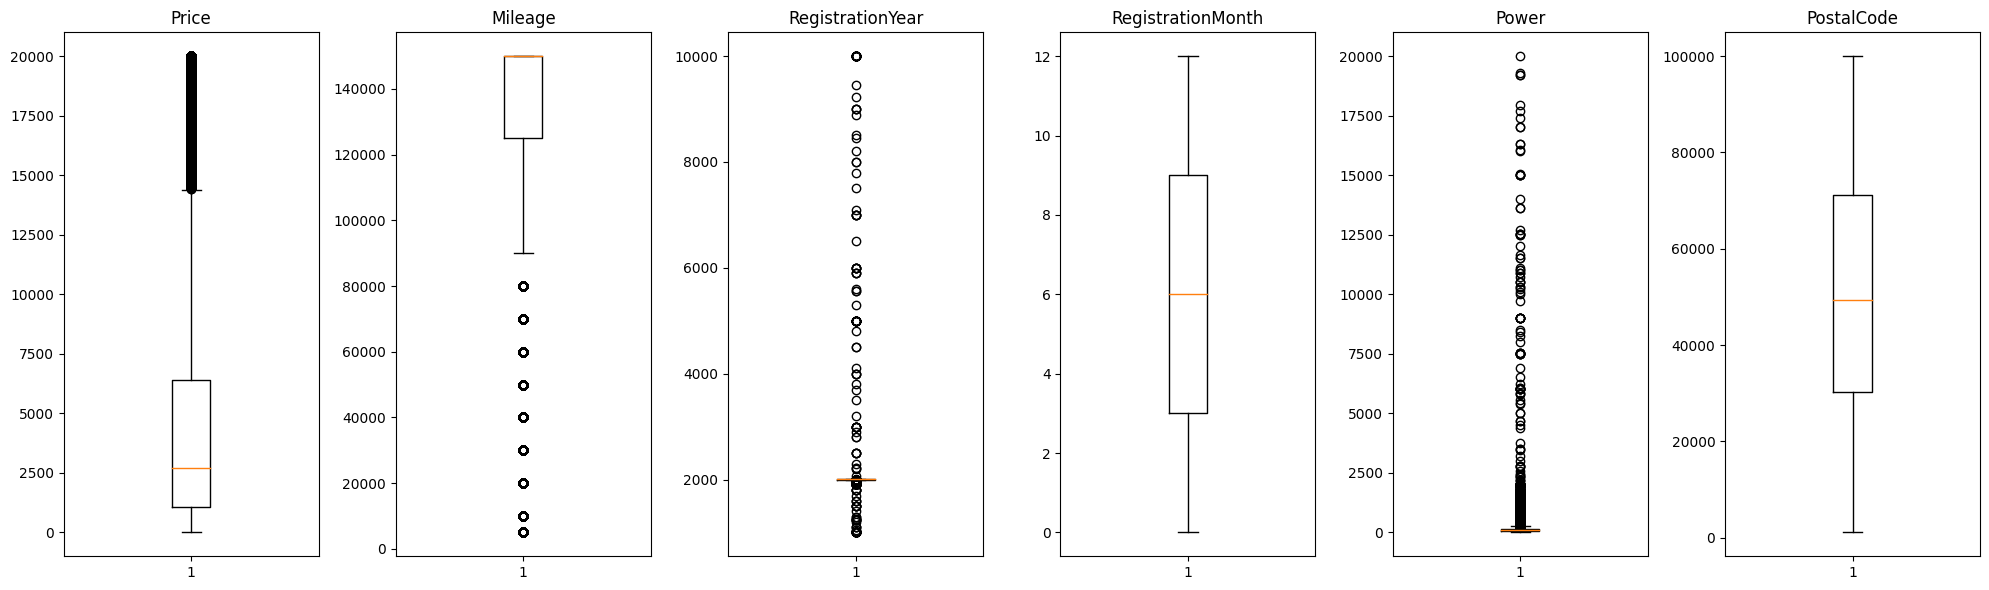

In [ ]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 6, figsize=(20, 6))

# Define the columns to plot
columns_to_plot = ['Price', 'Mileage', 'RegistrationYear', 'RegistrationMonth', 'Power', 'PostalCode']

# Plot the data
for i, column in enumerate(columns_to_plot):
    axes[i].boxplot(car_data_encoded[column])
    axes[i].set_title(column)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import chisquare

# Calculate the observed frequencies
observed_frequencies = car_data_encoded['RegistrationMonth'].value_counts()

# Calculate the expected frequencies under a uniform distribution
expected_frequencies = [len(car_data_encoded) / len(observed_frequencies)] * len(observed_frequencies)

# Perform the Chi-Squared Goodness-of-Fit test
chi2_statistic, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)

print("Chi-Squared Statistic:", chi2_statistic)
print("p-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis (Ho) and accept Ha. The months in which cars were registered are not uniformly distributed.")
else:
    print("Fail to reject the null hypothesis (Ho) and reject Ha. The frequencies in which cars were registered are uniformly distributed.")

Chi-Squared Statistic: 10393.974563237753
p-value: 0.0
Reject the null hypothesis (Ho) and accept Ha. The months in which cars were registered are not uniformly distributed.


**Comment:** Statistical analysis was light for this assignment, but I wanted to continue investigating whether there were any trends or irregularities in the distribution of certain variables. Then, I wanted to use some statistics, so I decided to test whether the distribution of months in ['RegistrationMonth'] is uniform. The result was that there is a large difference between the frequency of registrations in a given month such that it is not a uniform distribution.

## **Model Evaluation**

In [ ]:
features = car_data_encoded.drop('Price', axis=1)
target = car_data_encoded['Price']

In [ ]:
# train-test split

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.25, random_state = 12345) # split 25% of data to make validation set

### **Evaluating Gradient Boosting Classification Models**

* **GBM Regressor** – a boosting algorithm that is used for regression problems. It is similar to the GradientBoostingClassifier, but it uses a different loss function. The GradientBoostingRegressor uses a mean squared error loss function, while the GradientBoostingClassifier uses a log loss function.
      # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
* **AdaBoost Regressor** – a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction.
      # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
* **CatBoost Regressor** – xxxxxxxxxxxx
      # https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
* **XGBoost Regressor** – a supervised learning algorithm that uses gradient boosting to train a model for regression problems. It is a popular choice for regression tasks due to its high accuracy and efficiency.
      # https://xgboost.readthedocs.io/en/stable/python/index.html
* **LightGBM Regressor** –
      # https://lightgbm.readthedocs.io/en/stable/index.html

*Analyze the speed (%timeit cell_code; execution_time: %timeit -r 50 -n 1000 my_function()) and quality of models stored as individual variables for subsequent plotting; don't forget OHE for XGBoost*

### **Comparison with Weaker Learning Models**

* **Random Forest Regressor** – a regression algorithm that uses an ensemble of decision trees to predict continuous numerical values. It is similar to the Random Forest Classifier, but instead of predicting class labels, it predicts a real number.
      # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* **Decision Tree Regressor** – a machine learning algorithm that predicts a continuous numerical value. It works by splitting the data into subsets based on a series of if-else questions. The final prediction is made by averaging the values of the samples in the leaf node that the sample belongs to.
      # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
* **Linear Regression Regressor** – a statistical method that models the relationship between a dependent variable and one or more independent variables. It assumes that the relationship is linear, meaning that  the dependent variable can be predicted as a linear combination of the independent variables.
      # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

*Analyze the speed (%timeit cell_code; execution_time: %timeit -r 50 -n 1000 my_function()) and quality of models stored as individual variables for subsequent plotting; don't forget OHE for all models*

In [ ]:
model1 = GradientBoostingRegressor()
model2 = AdaBoostRegressor()
model3 = CatBoostRegressor()
model4 = XGBRegressor()
model5 = LGBMRegressor()
model6 = RandomForestRegressor()
model7 = DecisionTreeRegressor()
model8 = LinearRegression()

In [ ]:
def train_model1():
    model1.fit(features_train, target_train) # train model on training set
    predictions_valid = model1.predict(features_valid) # get model predictions on validation set
    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))# calculate RMSE on validation set
    r2_result = r2_score(target_valid, predictions_valid) # calculate R2 on validation set
    return result, r2_result

execution_time = timeit.timeit(train_model1, number=1)
result, r2_result = train_model1()
print("RMSE of the decision tree model on the validation set:", result)
print("R2 of the decision tree model on the validation set:", r2_result)
print("Execution Time:", execution_time, "seconds")

RMSE of the decision tree model on the validation set: 2075.605639102286
R2 of the decision tree model on the validation set: 0.7894478813833812
Execution Time: 34.88689216200055 seconds


In [ ]:
def train_model2():
    model2.fit(features_train, target_train) # train model on training set
    predictions_valid = model2.predict(features_valid) # get model predictions on validation set
    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))# calculate RMSE on validation set
    r2_result = r2_score(target_valid, predictions_valid) # calculate R2 on validation set
    return result, r2_result

execution_time = timeit.timeit(train_model2, number=1)
result, r2_result = train_model2()
print("RMSE of the decision tree model on the validation set:", result)
print("R2 of the decision tree model on the validation set:", r2_result)
print("Execution Time:", execution_time, "seconds")

RMSE of the decision tree model on the validation set: 3012.06027651802
R2 of the decision tree model on the validation set: 0.5565984070065658
Execution Time: 7.739925453999604 seconds


In [ ]:
def train_model3():
    model3.fit(features_train, target_train) # train model on training set
    predictions_valid = model3.predict(features_valid) # get model predictions on validation set
    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))# calculate RMSE on validation set
    r2_result = r2_score(target_valid, predictions_valid) # calculate R2 on validation set
    return result, r2_result

execution_time = timeit.timeit(train_model3, number=1)
result, r2_result = train_model3()
print("RMSE of the decision tree model on the validation set:", result)
print("R2 of the decision tree model on the validation set:", r2_result)
print("Execution Time:", execution_time, "seconds")

Learning rate set to 0.098913
0:	learn: 4237.3356317	total: 44.2ms	remaining: 44.2s
1:	learn: 3996.8212565	total: 81.8ms	remaining: 40.8s
2:	learn: 3781.5162712	total: 120ms	remaining: 39.8s
3:	learn: 3595.4169167	total: 156ms	remaining: 38.9s
4:	learn: 3427.9652840	total: 199ms	remaining: 39.5s
5:	learn: 3279.5147991	total: 235ms	remaining: 38.9s
6:	learn: 3149.9669583	total: 276ms	remaining: 39.1s
7:	learn: 3034.8090856	total: 316ms	remaining: 39.2s
8:	learn: 2939.0371768	total: 353ms	remaining: 38.9s
9:	learn: 2852.1046394	total: 391ms	remaining: 38.7s
10:	learn: 2775.9013613	total: 431ms	remaining: 38.8s
11:	learn: 2710.9416489	total: 468ms	remaining: 38.5s
12:	learn: 2653.5971478	total: 504ms	remaining: 38.2s
13:	learn: 2603.5315420	total: 540ms	remaining: 38s
14:	learn: 2555.4909125	total: 575ms	remaining: 37.7s
15:	learn: 2516.9448581	total: 612ms	remaining: 37.7s
16:	learn: 2482.1012420	total: 653ms	remaining: 37.7s
17:	learn: 2449.2112167	total: 688ms	remaining: 37.5s
18:	lear

In [ ]:
def train_model4():
    model4.fit(features_train, target_train) # train model on training set
    predictions_valid = model4.predict(features_valid) # get model predictions on validation set
    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))# calculate RMSE on validation set
    r2_result = r2_score(target_valid, predictions_valid) # calculate R2 on validation set
    return result, r2_result

execution_time = timeit.timeit(train_model4, number=1)
result, r2_result = train_model4()
print("RMSE of the decision tree model on the validation set:", result)
print("R2 of the decision tree model on the validation set:", r2_result)
print("Execution Time:", execution_time, "seconds")

RMSE of the decision tree model on the validation set: 1777.5809900661568
R2 of the decision tree model on the validation set: 0.8455710472984898
Execution Time: 1.9256156420005937 seconds


In [ ]:
def train_model5():
    model5.fit(features_train, target_train) # train model on training set
    predictions_valid = model5.predict(features_valid) # get model predictions on validation set
    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))# calculate RMSE on validation set
    r2_result = r2_score(target_valid, predictions_valid) # calculate R2 on validation set
    return result, r2_result

execution_time = timeit.timeit(train_model5, number=1)
result, r2_result = train_model5()
print("RMSE of the decision tree model on the validation set:", result)
print("R2 of the decision tree model on the validation set:", r2_result)
print("Execution Time:", execution_time, "seconds")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 265776, number of used features: 11
[LightGBM] [Info] Start training from score 4413.365319
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 265776, number of used features: 11
[LightGBM] [Info] Start training from score 4413.365319
RMSE of the decision tree model on the validation set: 1853.9854159307288
R2 of the decision tree model on the validation set: 0.8320103369894709
Execution Time: 3.050808539999707 se

In [ ]:
def train_model6():
    model6.fit(features_train, target_train) # train model on training set
    predictions_valid = model6.predict(features_valid) # get model predictions on validation set
    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))# calculate RMSE on validation set
    r2_result = r2_score(target_valid, predictions_valid) # calculate R2 on validation set
    return result, r2_result

execution_time = timeit.timeit(train_model6, number=1)
result, r2_result = train_model6()
print("RMSE of the decision tree model on the validation set:", result)
print("R2 of the decision tree model on the validation set:", r2_result)
print("Execution Time:", execution_time, "seconds")

RMSE of the decision tree model on the validation set: 1727.5226152318112
R2 of the decision tree model on the validation set: 0.8541463120518695
Execution Time: 180.74576448900007 seconds


In [ ]:
def train_model7():
    model7.fit(features_train, target_train) # train model on training set
    predictions_valid = model7.predict(features_valid) # get model predictions on validation set
    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))# calculate RMSE on validation set
    r2_result = r2_score(target_valid, predictions_valid) # calculate R2 on validation set
    return result, r2_result

execution_time = timeit.timeit(train_model7, number=1)
result, r2_result = train_model7()
print("RMSE of the decision tree model on the validation set:", result)
print("R2 of the decision tree model on the validation set:", r2_result)
print("Execution Time:", execution_time, "seconds")

RMSE of the decision tree model on the validation set: 2378.959006192939
R2 of the decision tree model on the validation set: 0.7234053034258252
Execution Time: 2.452925038000103 seconds


In [ ]:
def train_model8():
    model8.fit(features_train, target_train) # train model on training set
    predictions_valid = model8.predict(features_valid) # get model predictions on validation set
    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))# calculate RMSE on validation set
    r2_result = r2_score(target_valid, predictions_valid) # calculate R2 on validation set
    return result, r2_result

execution_time = timeit.timeit(train_model8, number=1)
result, r2_result = train_model8()
print("RMSE of the linear regression model on the validation set:", result)
print("R2 of the linear regression model on the validation set:", r2_result)
print("Execution Time:", execution_time, "seconds")

RMSE of the linear regression model on the validation set: 3648.510032349983
R2 of the linear regression model on the validation set: 0.34941953073901744
Execution Time: 0.1757860809993872 seconds


### **Visualization of Results**

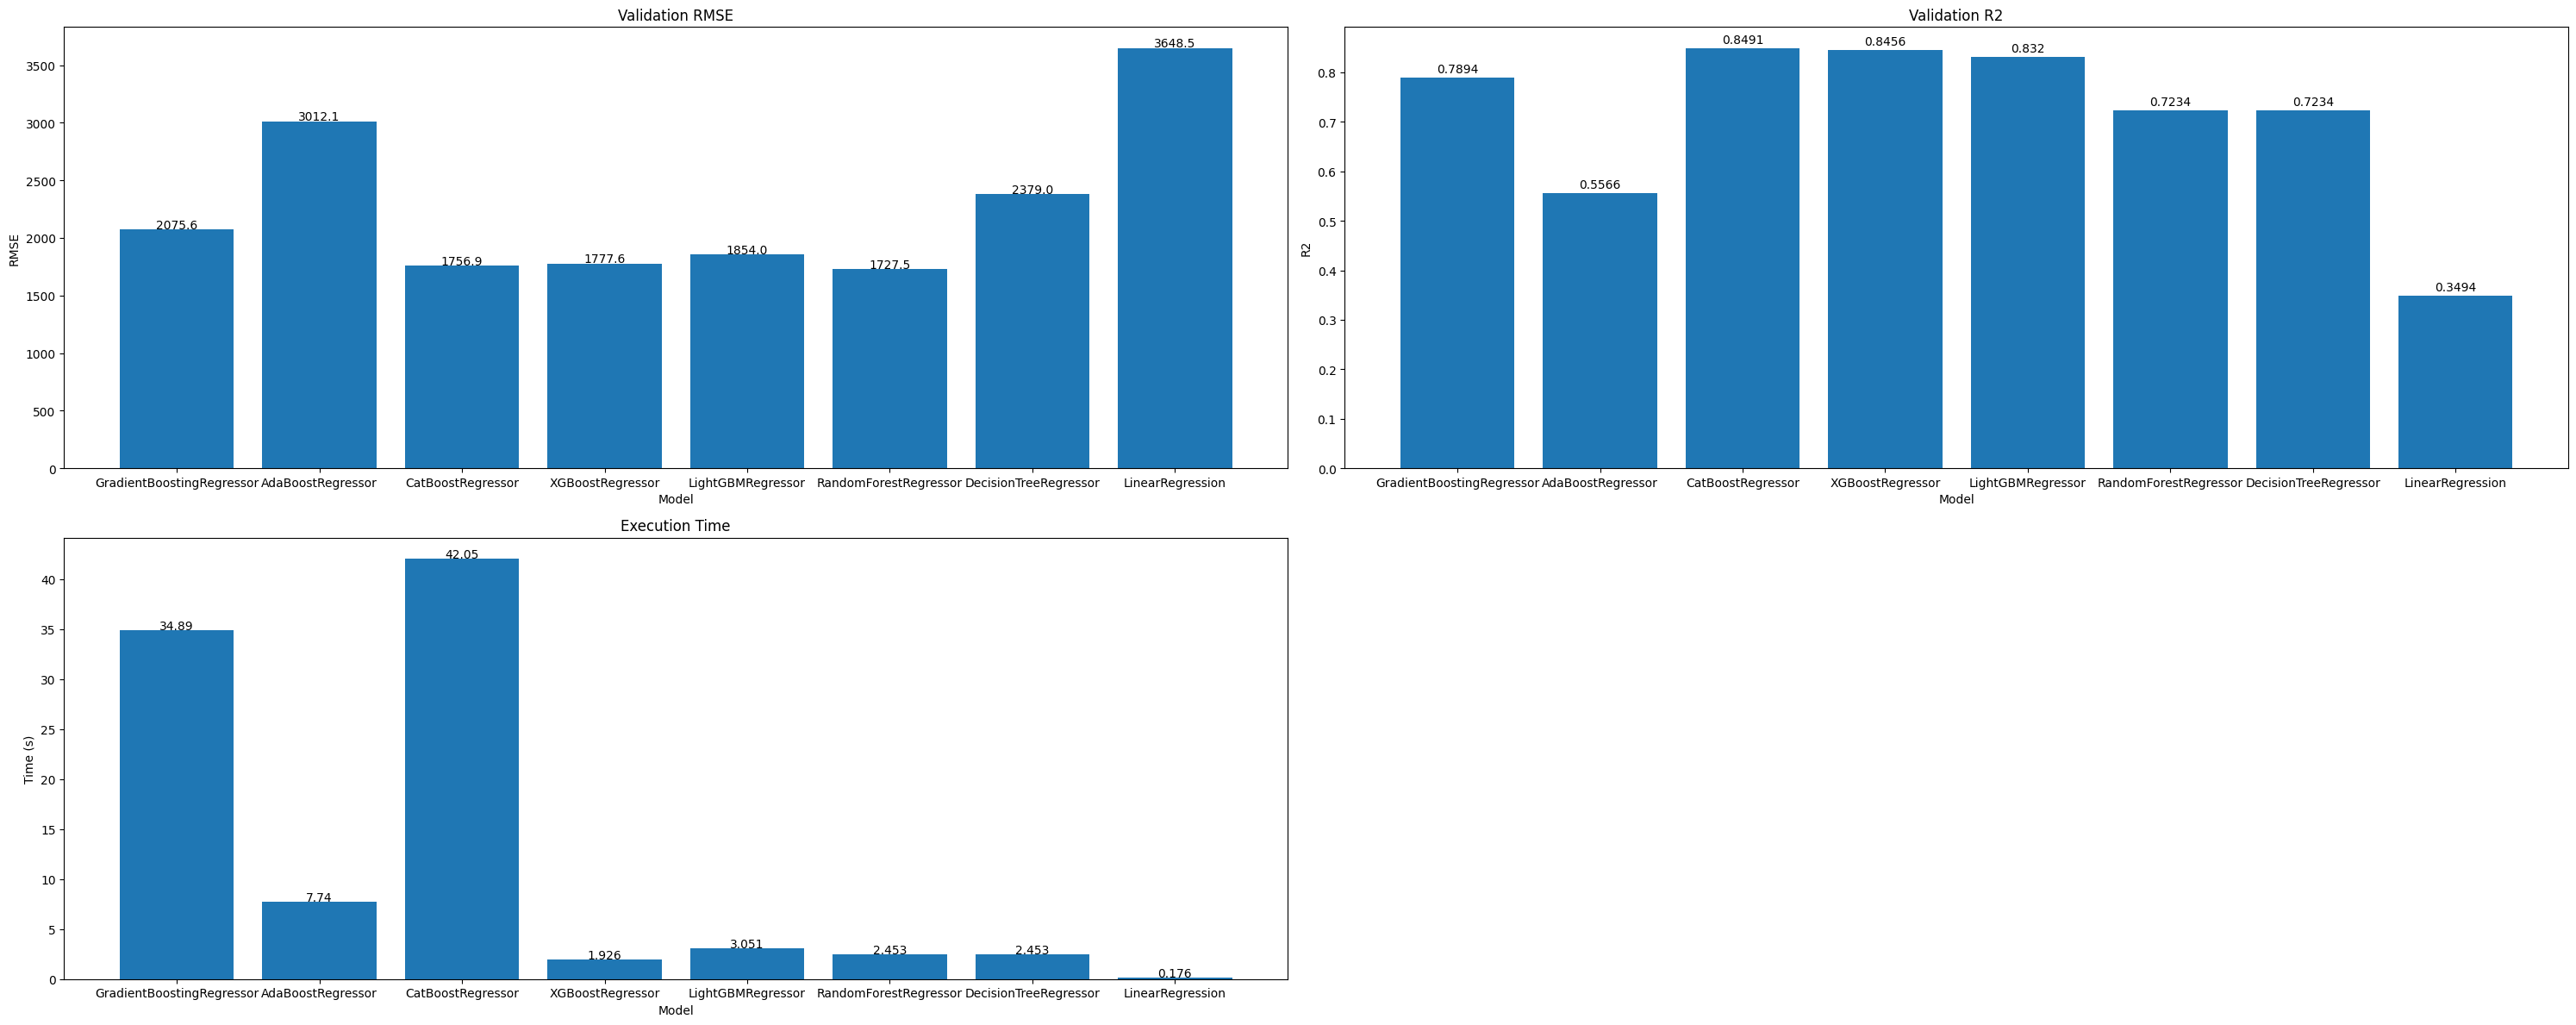

In [ ]:
model_names = ['GradientBoostingRegressor', 'AdaBoostRegressor', 'CatBoostRegressor', 'XGBoostRegressor', 'LightGBMRegressor', 'RandomForestRegressor', 'DecisionTreeRegressor', 'LinearRegression']
val_rmse = [2075.6, 3012.1, 1756.9, 1777.6, 1854.0, 1727.5, 2379.0, 3648.5]
val_r2 = [0.7894, 0.5566, 0.8491, 0.8456, 0.8320, 0.7234, 0.7234, 0.3494]
execution_time = [34.89, 7.740, 42.05, 1.926, 3.051, 2.453, 2.453, 0.176]

# Create a figure with 3 subplots
fig, axs = plt.subplots(2, 2, figsize=(30, 12))

# Plot the validation RMSE for each model
axs[0, 0].bar(model_names, val_rmse)
axs[0, 0].set_title('Validation RMSE')
axs[0, 0].set_xlabel('Model')
axs[0, 0].set_ylabel('RMSE')
for i, value in enumerate(val_rmse):
    axs[0, 0].text(i, value + 10, str(value), ha='center')

# Plot the validation R2 for each model
axs[0, 1].bar(model_names, val_r2)
axs[0, 1].set_title('Validation R2')
axs[0, 1].set_xlabel('Model')
axs[0, 1].set_ylabel('R2')
for i, value in enumerate(val_r2):
    axs[0, 1].text(i, value + 0.01, str(value), ha='center')

# Plot the execution time for each model
axs[1, 0].bar(model_names, execution_time)
axs[1, 0].set_title('Execution Time')
axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('Time (s)')
for i, value in enumerate(execution_time):
    axs[1, 0].text(i, value + 0.1, str(value), ha='center')

# Remove the empty subplot
fig.delaxes(axs[1, 1])

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

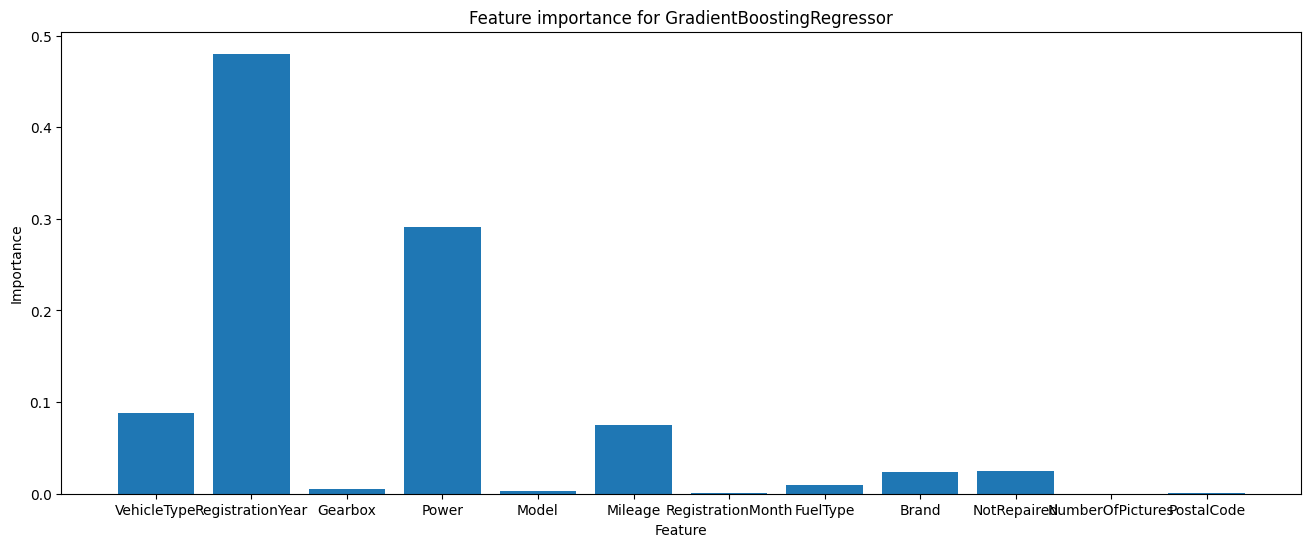

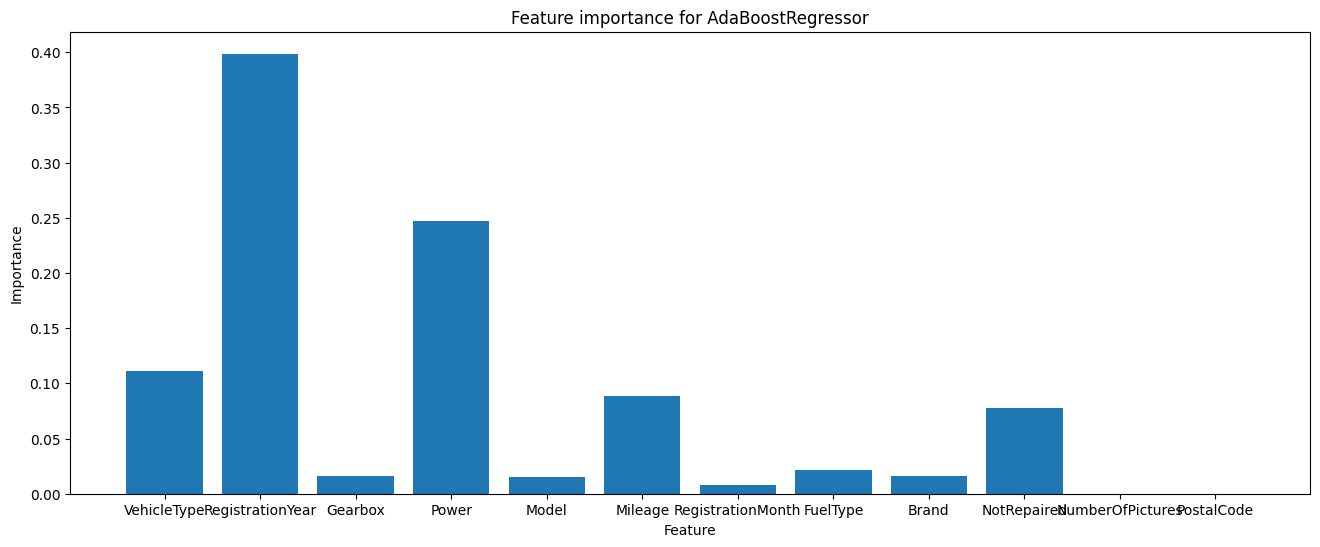

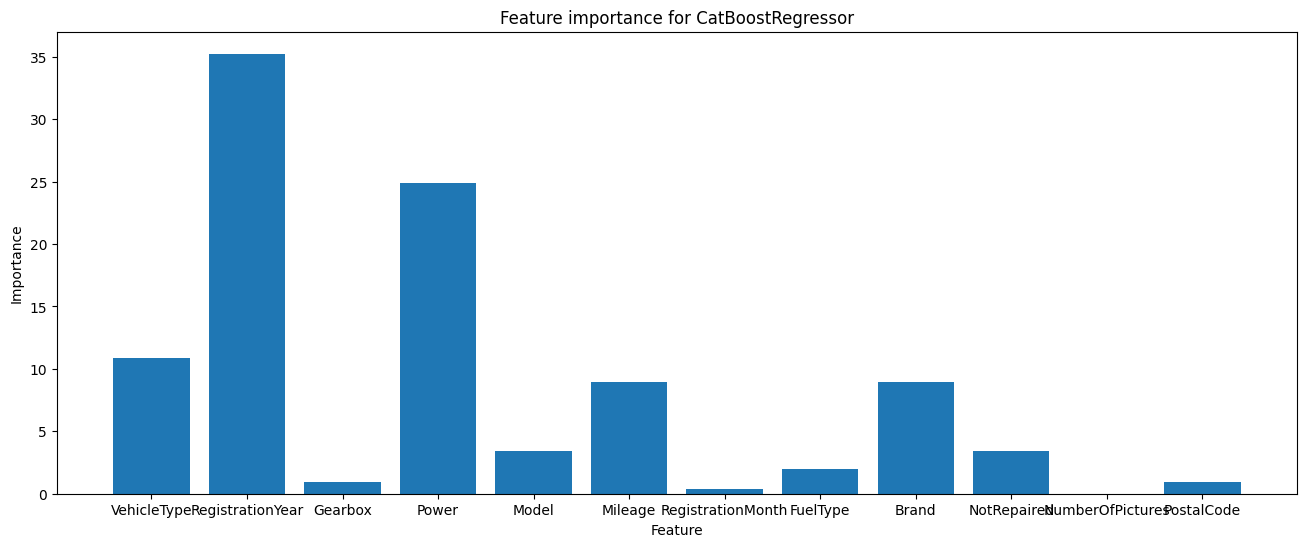

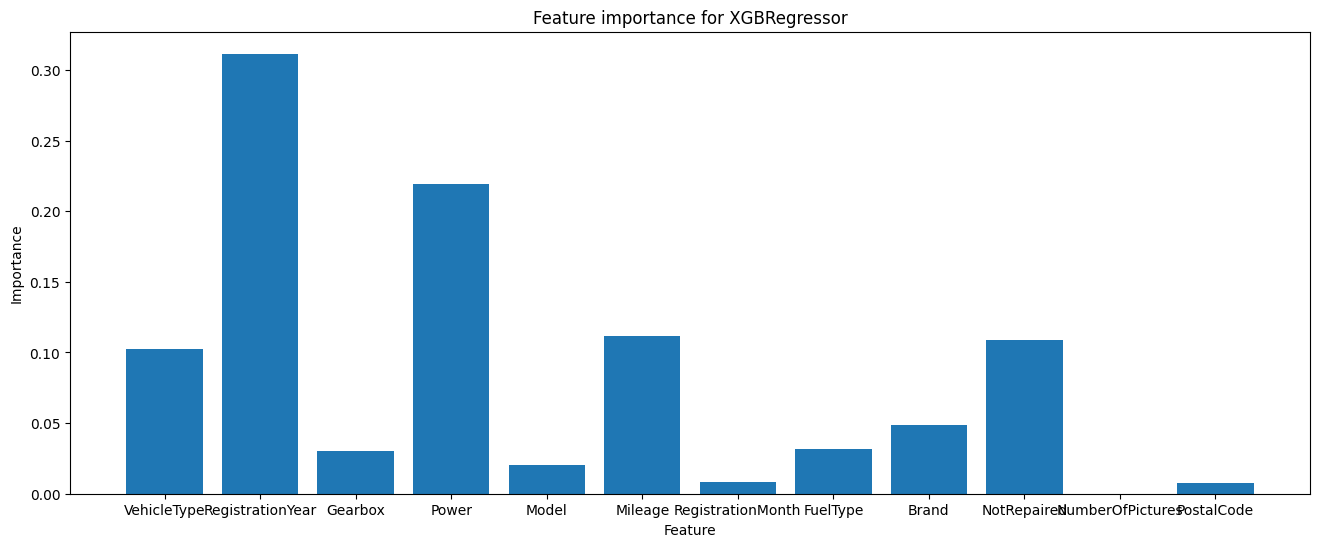

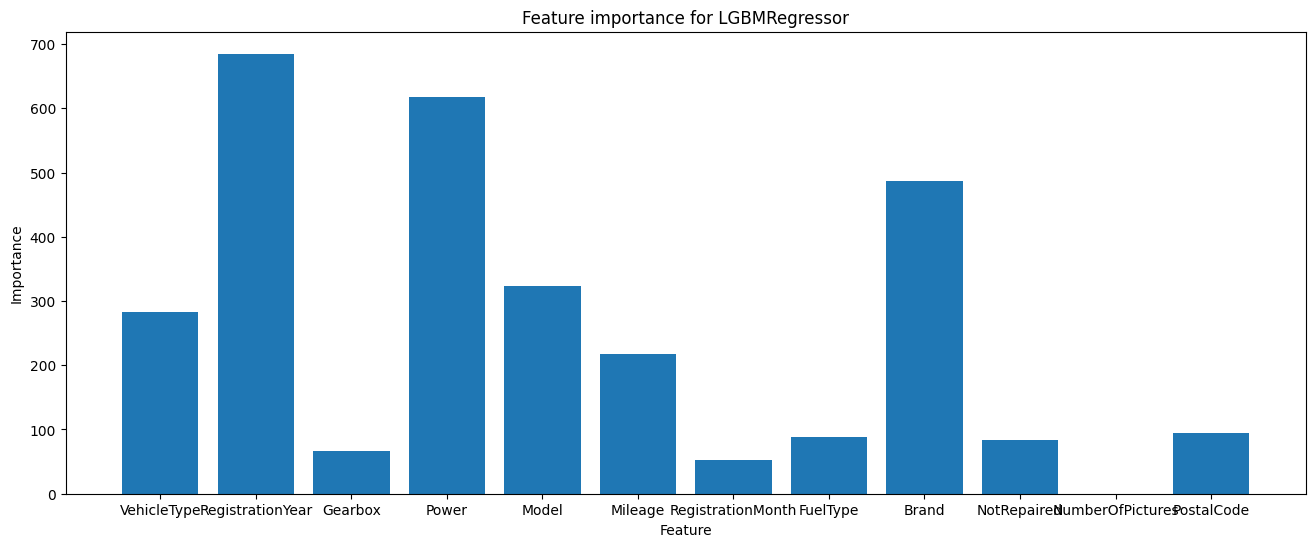

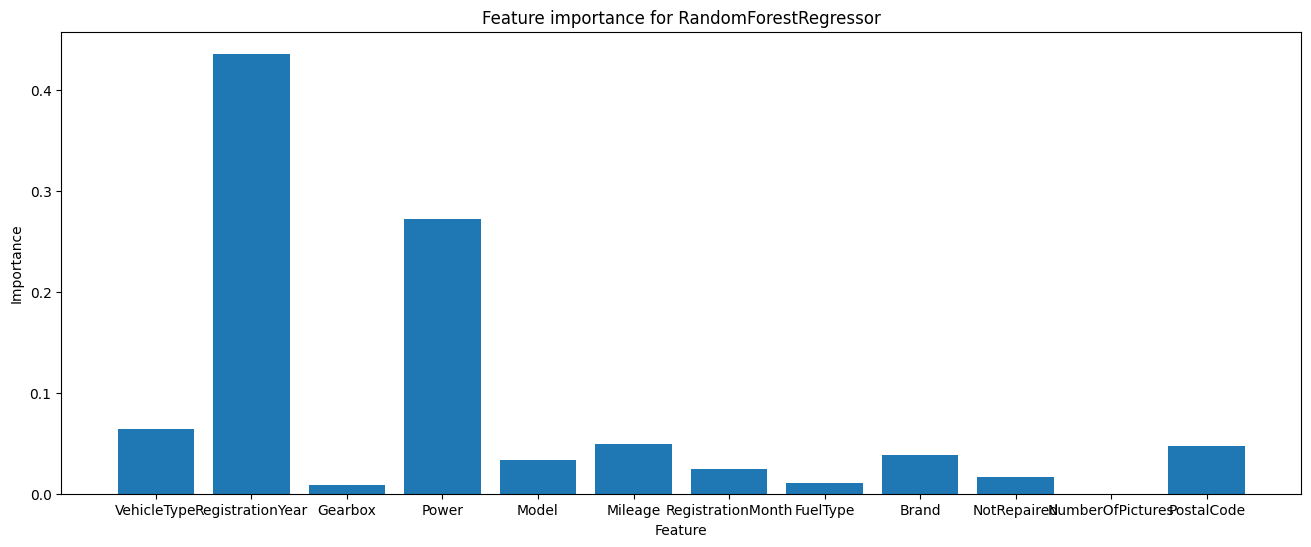

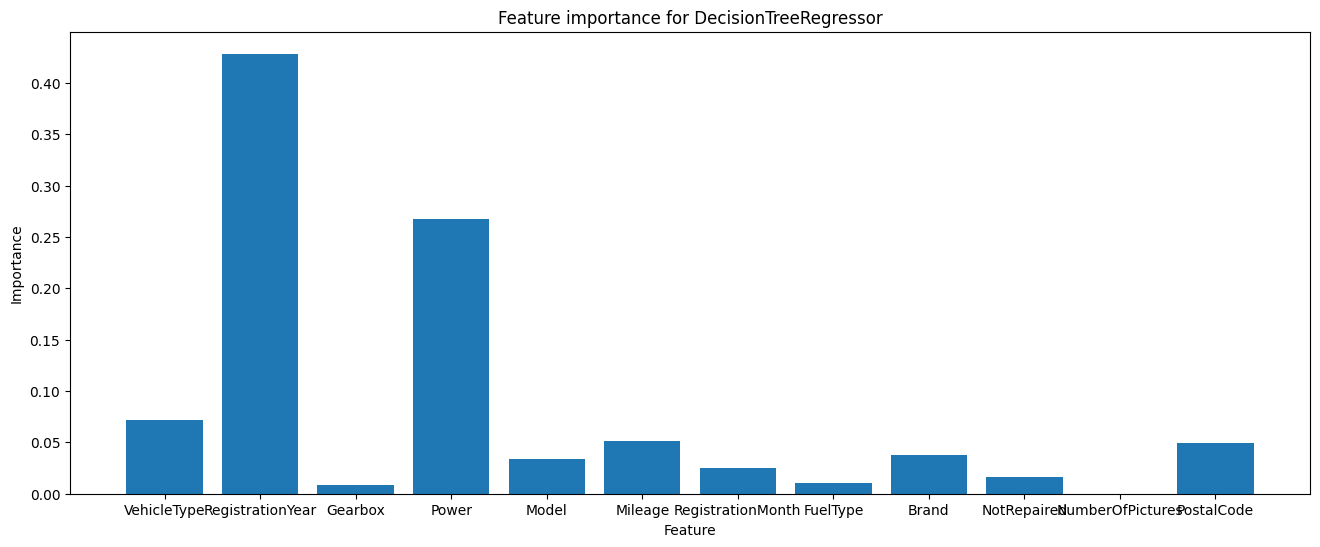

NameError: name 'coefficients' is not defined

<Figure size 1600x600 with 0 Axes>

In [ ]:
# Get feature names
feature_names = features_train.columns

# Plot feature importance for each model
plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance1)
plt.title("Feature importance for GradientBoostingRegressor")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance2)
plt.title("Feature importance for AdaBoostRegressor")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance3)
plt.title("Feature importance for CatBoostRegressor")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance4)
plt.title("Feature importance for XGBRegressor")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance5)
plt.title("Feature importance for LGBMRegressor")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance6)
plt.title("Feature importance for RandomForestRegressor")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(feature_names, feature_importance7)
plt.title("Feature importance for DecisionTreeRegressor")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# **General Conclusion**

Based on the results of my analysis, I found that CatBoost is the best regression model to predict price because of its lowest RMSE and highest R2 score and despite the longest execution time. This model is followed by